# Trabajo Práctico Nro. 4. R3.
### Ing. Javier Ouret - 2025 - UCA - Facultad de Ingeniería
## Cliente Servidor utilizando RestAPI. (Entrega 31/06/2025)

#### NOTA: este TP usa muchas ventanas terminales. Instalar Tilix para que sea más cómodo el cambio entre las pantallas.

#### Cliente en C que actúa como un sensor IoT, publicando datos al broker MQTT (Mosquitto).

- Se conecta al broker MQTT.
- Publica datos periódicamente (temperatura, CO₂, presión).
- Usa protocolo MQTT 3.1/3.1.1 compatible con Flask.
- Broker MQTT en funcionamiento (Mosquitto en localhost:1883).
- Librería MQTT para C: paho.mqtt.c

sensor_temp.c 

In [5]:
%%writefile sensor_mqtt.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include "MQTTClient.h"

#define ADDRESS     "tcp://localhost:1883"
#define CLIENTID    "SensorTempC"
#define TOPIC       "sensors/temp"
#define QOS         1
#define TIMEOUT     10000L

int main() {
    MQTTClient client;
    MQTTClient_connectOptions conn_opts = MQTTClient_connectOptions_initializer;
    MQTTClient_create(&client, ADDRESS, CLIENTID,
                      MQTTCLIENT_PERSISTENCE_NONE, NULL);

    conn_opts.keepAliveInterval = 20;
    conn_opts.cleansession = 1;

    if (MQTTClient_connect(client, &conn_opts) != MQTTCLIENT_SUCCESS) {
        printf("Error conectando al broker MQTT\n");
        return 1;
    }

    printf("Conectado al broker MQTT\n");

    for (int i = 0; i < 100; i++) {
        char payload[100];
        float valor = 20.0 + rand() % 10 + ((float) rand() / RAND_MAX);  // valor entre 20–30
        snprintf(payload, sizeof(payload), "{\"sensor\":\"temp\",\"value\":%.2f}", valor);

        MQTTClient_message pubmsg = MQTTClient_message_initializer;
        pubmsg.payload = payload;
        pubmsg.payloadlen = (int)strlen(payload);
        pubmsg.qos = QOS;
        pubmsg.retained = 0;

        MQTTClient_deliveryToken token;
        MQTTClient_publishMessage(client, TOPIC, &pubmsg, &token);
        MQTTClient_waitForCompletion(client, token, TIMEOUT);

        printf("Publicado: %s\n", payload);
        sleep(5);  // Esperar 5 segundos
    }

    MQTTClient_disconnect(client, 10000);
    MQTTClient_destroy(&client);
    return 0;
}


Overwriting sensor_mqtt.c


Ejecutar

Debe verse:

Modificar el código anterior para simular sensores de presión y CO₂ cambiando, por ejemplo:
- TOPIC = "sensors/presion"
- CLIENTID = "SensorPresionC"

Luego generar otros 2 programas en C para simular humedad y CO2:
- sensor_co2.c
- sensor_presion.c

#### Gateway Flask
##### Objetivo: actuar de pasarela enntre los sensores (a través del broker MQTT) y enviar los datos al cliente web si requerir que el cliente los solicite.

- Se conecta al broker MQTT (localhost:1883)
- Se suscribe a tópicos sensors/#
- Cada vez que llega un dato:
  - Lo almacena en SQLite
  - Lo reenvía por WebSocket a la interfaz web
- Cada mensaje MQTT que llega (desde sensores C):
  - Se imprime en consola.
  - Se guarda en la base de datos.
  - Se envía a la interfaz en tiempo real vía WebSocket (sensor_data).
  - Usamos Flask como microframework para crear este servidor.  

#### Notas
- Evitar:
  - Errores de importación circular.
  - Problemas de contexto de app.py o socketio en módulos externos
  - Errores al pasar referencias (como socketio.emit) entre archivos
- eventlet.monkey_patch() debe estar al inicio en la primera línea, antes de cualquier import de Flask o SocketIO.
  - Si no está, el servidor puede levantar, pero los WebSockets fallan sin avisos.
- Uso correcto de socketio.emit fuera de contexto HTTP
  - No usar request, current_app ni app_context, lo que evita errores como:
  - "RuntimeError: Working outside of application context."
- Uso explícito de transports: ['websocket'] en el navegador.
  - Fuerza que la conexión se haga por WebSocket puro (sin polling fallback), lo cual evita problemas de CORS y fallos sin aviso en entornos que no tienen soporte al polling.

In [6]:
%%writefile requirements.txt
Flask
Flask-SocketIO
eventlet
paho-mqtt
flask_sqlalchemy

Overwriting requirements.txt


#### Nota
Antes de continuar verificar que estos código integrados funcionan, para verificar compatibilidad del cliente web con websockets.
- app_prueba1.py: sin MQTT
- app_prueba2.py: con MQTT   


In [7]:
%%writefile flask_gateway/app_prueba1.py
import eventlet
eventlet.monkey_patch()

from flask import Flask, render_template_string
from flask_socketio import SocketIO

app = Flask(__name__)
# Esta línea es necesaria durante el desarrollo
app.config['SECRET_KEY'] = 'secreto'
socketio = SocketIO(app, cors_allowed_origins="*")

html = '''
<!DOCTYPE html>
<html>
<head>
<script src="https://cdn.socket.io/3.1.3/socket.io.min.js"></script>
</head>
<body>
<h2>Test Socket.IO</h2>
<ul id="messages"></ul>
<script>
  var socket = io();
  socket.on('connect', () => console.log('Connected!'));
  socket.on('message', data => {
    console.log('Received:', data);
    var li = document.createElement('li');
    li.textContent = data;
    document.getElementById('messages').appendChild(li);
  });
</script>
</body>
</html>
'''

@app.route('/')
def index():
    return render_template_string(html)

def send_messages():
    import time
    while True:
        with app.app_context():
            socketio.emit('message', 'Mensaje desde el servidor!')
        socketio.sleep(3)

@socketio.on('connect')
def on_connect():
    print('Cliente conectado')

if __name__ == '__main__':
    socketio.start_background_task(send_messages)
    socketio.run(app, host='0.0.0.0', port=5000)


Overwriting flask_gateway/app_prueba1.py


In [8]:
%%writefile flask_gateway/app_prueba2.py
import eventlet
eventlet.monkey_patch()

from flask import Flask, render_template_string
from flask_socketio import SocketIO
import paho.mqtt.client as mqtt
import json
import threading

app = Flask(__name__)
# Esta línea es necesaria durante el desarrollo
app.config['SECRET_KEY'] = 'secreto'
socketio = SocketIO(app, cors_allowed_origins="*")

# HTML embebido para prueba directa
HTML = '''
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <script src="https://cdn.socket.io/3.1.3/socket.io.min.js"></script>
</head>
<body>
<h2>Datos desde MQTT</h2>
<ul id="mensajes"></ul>
<script>
    const socket = io({ transports: ['websocket'] });

    socket.on('connect', () => {
        console.log('Conectado!');
    });

    socket.on('nueva_lectura', function(data) {
        console.log('Recibido:', data);
        const li = document.createElement('li');
        li.textContent = `Sensor: ${data.sensor} - Valor: ${data.value}`;
        document.getElementById('mensajes').prepend(li);
    });

    socket.on('disconnect', () => {
        console.warn("Desconectado del WebSocket");
    });

    socket.on('connect_error', err => {
        console.error('Error de conexión:', err.message);
    });
</script>
</body>
</html>
'''

@app.route('/')
def index():
    return render_template_string(HTML)

@socketio.on('connect')
def on_connect():
    print('Cliente web conectado al WebSocket')

def on_mqtt_message(client, userdata, msg):
    print("MQTT recibido:", msg.payload)
    try:
        data = json.loads(msg.payload.decode())
        print("Emitiendo a WebSocket:", data)
        socketio.emit('nueva_lectura', data)
    except Exception as e:
        print("Error al parsear MQTT:", e)

def mqtt_thread():
    mqttc = mqtt.Client()
    mqttc.on_message = on_mqtt_message
    mqttc.connect("localhost", 1883, 60)
    mqttc.subscribe("sensors/temp")
    print("MQTT conectado y suscripto a sensors/temp")
    mqttc.loop_forever()

if __name__ == '__main__':
    threading.Thread(target=mqtt_thread, daemon=True).start()
    socketio.run(app, host='0.0.0.0', port=5000)


Overwriting flask_gateway/app_prueba2.py


#### Si los códigos anteriores funcionaron correctamente separamos ahora la aplicación en módulos.
- app.py: aplicación principal. Servidor Flask + WebSocket.
- mqtt_receiver.py: conecta al broker MQTT, guarda en BD y emite por WebSocket.
- templates/base.html: menu de inicio.
- templates/home.html: página principal con canvas de gráficos.
- templates/panel.html: panel de control.
- templates/historial.html: historial de datos.
- static/css/style.css:	estilo de la interfaz.


#### Importante:
Tener funcionando los simuladores de sensores, el gestor MQTT.
Se puede probar que MQTT funciona, por fuera de la aplicación suscribiéndose con:

#### Aplicacion principal app.py

In [9]:
%%writefile flask_gateway/app.py
import eventlet
eventlet.monkey_patch()

from flask import Flask, render_template
from flask_socketio import SocketIO
from mqtt_receiver import start_mqtt_thread  # importa hilo MQTT

app = Flask(__name__)
app.config['SECRET_KEY'] = 'secreto'
socketio = SocketIO(app, cors_allowed_origins="*")

@app.route('/')
def index():
    return render_template("home.html")

@app.route('/panel')
def panel():
    return render_template("panel.html")

@app.route("/historial")
def historial():
    import sqlite3
    conn = sqlite3.connect("sensores.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM lecturas ORDER BY timestamp DESC LIMIT 100")
    rows = cursor.fetchall()
    conn.close()
    return render_template("historial.html", datos=rows)

@socketio.on('connect')
def on_connect():
    print("Cliente web conectado")

if __name__ == "__main__":
    start_mqtt_thread(socketio)
    print("Servidor accesible en el siguiente puerto: http://localhost:5000")
    socketio.run(app, host="0.0.0.0", port=5000)


Overwriting flask_gateway/app.py


#### Crear mqtt_receiver.py   
Este módulo corre en background como hilo del broker MQTT y se integra con SocketIO. Su función es acceder al gestor o broker. Es llamado desde app.py.

In [10]:
%%writefile flask_gateway/mqtt_receiver.py
import threading
import paho.mqtt.client as mqtt
import json
import sqlite3
import time

# Inicializar base de datos
def init_db():
    conn = sqlite3.connect("sensores.db")
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS lecturas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            sensor TEXT,
            valor REAL,
            timestamp TEXT
        )
    ''')
    conn.commit()
    conn.close()

# Insertar lectura
def guardar_lectura(sensor, valor):
    conn = sqlite3.connect("sensores.db")
    c = conn.cursor()
    c.execute("INSERT INTO lecturas (sensor, valor, timestamp) VALUES (?, ?, datetime('now'))", (sensor, valor))
    conn.commit()
    conn.close()

def start_mqtt_thread(socketio):
    init_db()  # Inicializar DB al comenzar

    def on_message(client, userdata, msg):
        try:
            payload = json.loads(msg.payload.decode())
            sensor = payload.get("sensor")
            valor = float(payload.get("value"))

            print(f"MQTT: sensor={sensor}, valor={valor}")
            guardar_lectura(sensor, valor)

            socketio.emit("nueva_lectura", {"sensor": sensor, "value": valor})
        except Exception as e:
            print("Error al procesar mensaje MQTT:", e)

    def mqtt_loop():
        client = mqtt.Client()
        client.connect("localhost", 1883, 60)
        client.subscribe("sensors/temp")
        client.on_message = on_message
        client.loop_forever()

    # Lanzar MQTT en hilo separado
    hilo = threading.Thread(target=mqtt_loop)
    hilo.daemon = True
    hilo.start()


Overwriting flask_gateway/mqtt_receiver.py


In [11]:
%%writefile flask_gateway/templates/base.html
<!DOCTYPE html>
<html lang="es">
<head>
  <meta charset="UTF-8">
  <title>{% block title %}Dashboard MQTT{% endblock %}</title>

  <!-- Bootstrap 5 -->
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
  <!-- Estilo personalizado -->
  <link rel="stylesheet" href="{{ url_for('static', filename='styles.css') }}">
  {% block head_scripts %}{% endblock %}
</head>
<body class="bg-light text-dark">

<nav class="navbar navbar-expand-lg navbar-light bg-white border-bottom">
  <div class="container-fluid">
    <a class="navbar-brand fw-bold" href="/">Sensores MQTT</a>
    <div>
      <a href="/" class="btn btn-outline-primary me-2">Panel</a>
      <a href="/historial" class="btn btn-outline-secondary">Historial</a>
    </div>
  </div>
</nav>

<div class="container py-4">
  {% block content %}{% endblock %}
</div>

{% block footer_scripts %}{% endblock %}
</body>
</html>



Overwriting flask_gateway/templates/base.html


In [12]:
%%writefile flask_gateway/templates/panel.html
{% extends 'base.html' %}

{% block title %}Panel MQTT{% endblock %}

{% block head_scripts %}
<script src="https://cdn.socket.io/3.1.3/socket.io.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
{% endblock %}

{% block content %}
<div class="d-flex justify-content-between align-items-center mb-4">
  <h2 class="fw-bold">Panel de Sensores MQTT</h2>
  <div>
    <button class="btn btn-dark me-2" onclick="mostrarConsola()">🖥️ Consola</button>
    <button class="btn btn-primary" onclick="mostrarGrafico()">📈 Gráfico</button>
  </div>
</div>

<div id="consolaContainer" class="mb-4">
  <div id="consola">
    <ul id="mensajes" class="list-unstyled mb-0"></ul>
  </div>
</div>

<div id="graficoContainer" class="card bg-white p-3 d-none">
  <canvas id="graficoTemp"></canvas>
</div>
{% endblock %}

{% block footer_scripts %}
<script>
  const socket = io({ transports: ['websocket'] });
  const ctx = document.getElementById('graficoTemp').getContext('2d');
  const chart = new Chart(ctx, {
    type: 'line',
    data: {
      labels: [],
      datasets: [{
        label: 'Temperatura (°C)',
        data: [],
        borderColor: 'rgb(13,110,253)',
        backgroundColor: 'rgba(13,110,253,0.2)',
        tension: 0.4
      }]
    },
    options: {
      scales: {
        y: { min: 0, max: 50 }
      },
      plugins: {
        legend: { labels: { color: '#000' } }
      }
    }
  });

  socket.on('connect', () => {
    console.log('Conectado al WebSocket');
  });

  socket.on('nueva_lectura', (data) => {
    const hora = new Date().toLocaleTimeString();
    const li = document.createElement('li');
    li.textContent = `[${hora}] Sensor: ${data.sensor} | Valor: ${data.value}`;
    document.getElementById('mensajes').prepend(li);

    if (data.sensor === "temp") {
      chart.data.labels.push(hora);
      chart.data.datasets[0].data.push(data.value);
      if (chart.data.labels.length > 20) {
        chart.data.labels.shift();
        chart.data.datasets[0].data.shift();
      }
      chart.update();
    }
  });

  socket.on('disconnect', () => console.warn('Desconectado'));
  socket.on('connect_error', err => console.error('Error:', err.message));

  function mostrarConsola() {
    document.getElementById('consolaContainer').classList.remove('d-none');
    document.getElementById('graficoContainer').classList.add('d-none');
  }

  function mostrarGrafico() {
    document.getElementById('consolaContainer').classList.add('d-none');
    document.getElementById('graficoContainer').classList.remove('d-none');
  }
</script>
{% endblock %}


Overwriting flask_gateway/templates/panel.html


In [13]:
%%writefile flask_gateway/templates/historial.html
{% extends 'base.html' %}

{% block title %}Historial de Lecturas{% endblock %}

{% block content %}
<h2 class="fw-bold mb-4">📋 Historial de Lecturas</h2>

<div class="table-responsive">
  <table class="table table-striped table-hover bg-white">
    <thead class="table-light">
      <tr>
        <th>ID</th>
        <th>Sensor</th>
        <th>Valor</th>
        <th>Fecha y Hora</th>
      </tr>
    </thead>
    <tbody>
      {% for row in datos %}
      <tr>
        <td>{{ row[0] }}</td>
        <td>{{ row[1] }}</td>
        <td>{{ row[2] }}</td>
        <td>{{ row[3] }}</td>
      </tr>
      {% endfor %}
    </tbody>
  </table>
</div>
{% endblock %}


Overwriting flask_gateway/templates/historial.html


In [14]:
%%writefile flask_gateway/templates/home.html
{% extends 'base.html' %}

{% block title %}Inicio - Sensores MQTT{% endblock %}

{% block content %}
<div class="text-center py-5">
  <h1 class="mb-4 fw-bold">Sistema de Monitoreo MQTT</h1>
  <p class="lead">Seleccionar una opción para comenzar:</p>

  <div class="d-flex justify-content-center gap-4 mt-4">
    <a href="/panel" class="btn btn-primary btn-lg">
      Panel Tiempo Real
    </a>
    <a href="/historial" class="btn btn-secondary btn-lg">
      Historial de Datos
    </a>
  </div>
</div>
{% endblock %}


Overwriting flask_gateway/templates/home.html


In [15]:
%%writefile flask_gateway/static/styles.css
#consola {
  background-color: #f8f9fa;
  color: #212529;
  font-family: monospace;
  padding: 1rem;
  height: 300px;
  overflow-y: auto;
  border: 1px solid #dee2e6;
  border-radius: 0.5rem;
}



Overwriting flask_gateway/static/styles.css


### Consigna del TP 
**Ejercicios a realizar durante la clase. Incluir los códigos dentro de este mismo Notebook**

- Modificar todos los códigos para agregar simulación de CO2 y Presión.
- Verificar como funciona websocket y explicar.
- Verificar como funciona MQTT y explicar.
- Explicar simulador de sensor en C.
- Mostrar resultados. Graficar y Consola, extendiendo el ejemplo.

### RESPUESTAS

**1) Modificar todos los códigos para agregar simulación de CO2 y Presión.**

Modifico los codigos de sensores adaptando uno para presion, otro para CO2. Sin embargo como estoy trabajando en windows, vi más conveniente utilizar python en vez de C por ende el codigo a utilizar para las pruebas es el sensor_temp.py

sensor_temp.py

In [ ]:
import time, json, random
import paho.mqtt.client as mqtt

client = mqtt.Client()
client.connect("localhost", 1883, 60)

while True:
    valor = round(random.uniform(400, 600), 2)
    mensaje = json.dumps({"sensor": "co2", "value": valor})
    client.publish("sensors/co2", mensaje)
    print("Publicado:", mensaje)
    time.sleep(5)


sensor_presion.c

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include "MQTTClient.h"

#define ADDRESS     "tcp://localhost:1883"
#define CLIENTID    "SensorPresionC"
#define TOPIC       "sensors/presion"
#define QOS         1
#define TIMEOUT     10000L

int main() {
    MQTTClient client;
    MQTTClient_connectOptions conn_opts = MQTTClient_connectOptions_initializer;
    MQTTClient_create(&client, ADDRESS, CLIENTID, MQTTCLIENT_PERSISTENCE_NONE, NULL);

    conn_opts.keepAliveInterval = 20;
    conn_opts.cleansession = 1;

    if (MQTTClient_connect(client, &conn_opts) != MQTTCLIENT_SUCCESS) {
        printf("Error conectando al broker MQTT\n");
        return 1;
    }

    printf("Conectado al broker MQTT\n");

    for (int i = 0; i < 100; i++) {
        char payload[100];
        float valor = 900.0 + rand() % 100 + ((float) rand() / RAND_MAX);  // valor entre 900–1000
        snprintf(payload, sizeof(payload), "{\"sensor\":\"presion\",\"value\":%.2f}", valor);

        MQTTClient_message pubmsg = MQTTClient_message_initializer;
        pubmsg.payload = payload;
        pubmsg.payloadlen = (int)strlen(payload);
        pubmsg.qos = QOS;
        pubmsg.retained = 0;

        MQTTClient_deliveryToken token;
        MQTTClient_publishMessage(client, TOPIC, &pubmsg, &token);
        MQTTClient_waitForCompletion(client, token, TIMEOUT);

        printf("Publicado: %s\n", payload);
        sleep(5);
    }

    MQTTClient_disconnect(client, 10000);
    MQTTClient_destroy(&client);
    return 0;
}


sensor_co2.c

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>
#include "MQTTClient.h"

#define ADDRESS     "tcp://localhost:1883"
#define CLIENTID    "SensorCO2C"
#define TOPIC       "sensors/co2"
#define QOS         1
#define TIMEOUT     10000L

int main() {
    MQTTClient client;
    MQTTClient_connectOptions conn_opts = MQTTClient_connectOptions_initializer;
    MQTTClient_create(&client, ADDRESS, CLIENTID, MQTTCLIENT_PERSISTENCE_NONE, NULL);

    conn_opts.keepAliveInterval = 20;
    conn_opts.cleansession = 1;

    if (MQTTClient_connect(client, &conn_opts) != MQTTCLIENT_SUCCESS) {
        printf("Error conectando al broker MQTT\n");
        return 1;
    }

    printf("Conectado al broker MQTT\n");

    for (int i = 0; i < 100; i++) {
        char payload[100];
        float valor = 400.0 + rand() % 200 + ((float) rand() / RAND_MAX);  // valor entre 400–600
        snprintf(payload, sizeof(payload), "{\"sensor\":\"co2\",\"value\":%.2f}", valor);

        MQTTClient_message pubmsg = MQTTClient_message_initializer;
        pubmsg.payload = payload;
        pubmsg.payloadlen = (int)strlen(payload);
        pubmsg.qos = QOS;
        pubmsg.retained = 0;

        MQTTClient_deliveryToken token;
        MQTTClient_publishMessage(client, TOPIC, &pubmsg, &token);
        MQTTClient_waitForCompletion(client, token, TIMEOUT);

        printf("Publicado: %s\n", payload);
        sleep(5);
    }

    MQTTClient_disconnect(client, 10000);
    MQTTClient_destroy(&client);
    return 0;
}


**2) Verificar como funciona websocket y explicar.**

WebSocket permite una conexión persistente entre el cliente (navegador) y el servidor Flask:

Al conectar el cliente (socket = io({ transports: ['websocket'] })), se abre un canal bidireccional.

El servidor puede enviar datos en tiempo real sin que el cliente tenga que pedirlos (a diferencia de HTTP).

Se usa socketio.emit('nueva_lectura', data) para enviar datos desde el backend al navegador.

Los datos llegan al frontend y se representan en consola o gráfico (chart.update()).

Esta conexión permanece abierta mientras el usuario tenga la página abierta.

**3) Verificar como funciona MQTT y explicar.**

MQTT (Message Queue Telemetry Transport) es un protocolo ligero ideal para sensores:

Usa el modelo publicador/suscriptor.

Los sensores en C son publicadores y envían mensajes a tópicos como sensors/temp.

El servidor Flask (gateway) se suscribe a estos tópicos.

Cada vez que llega un mensaje, Flask:

Lo guarda en SQLite.

Lo muestra en consola.

Lo envía a la interfaz por WebSocket.

El broker MQTT (Mosquitto) corre en localhost:1883 y distribuye mensajes a quienes estén suscriptos.

**4) Explicar simulador de sensor en C.**

Cada programa en C:

Crea un cliente MQTT con un CLIENTID único.

Se conecta al broker.

En un bucle de 100 iteraciones, genera un valor aleatorio, lo empaqueta en JSON ({"sensor":"temp","value":26.8}), y lo publica en un tópico (sensors/temp).

Luego espera 5 segundos y repite.

Este comportamiento emula un sensor real que reporta datos periódicamente.

**5) Mostrar resultados. Graficar y Consola, extendiendo el ejemplo.**

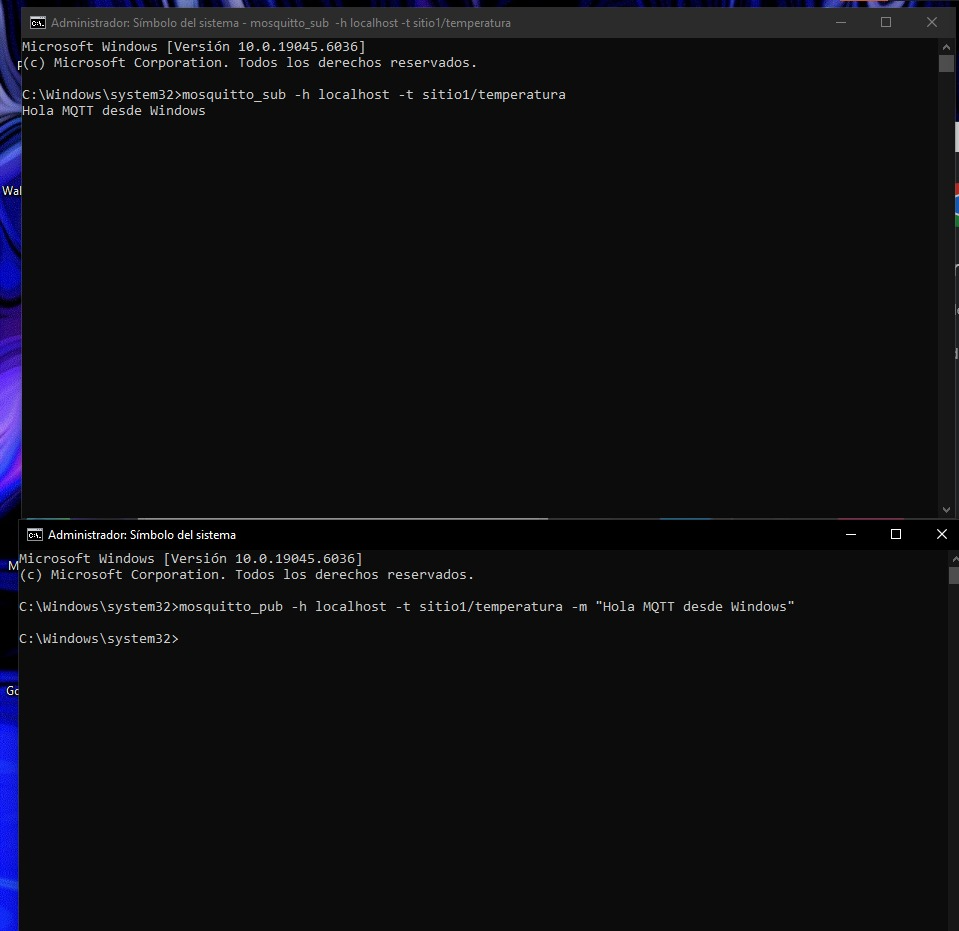
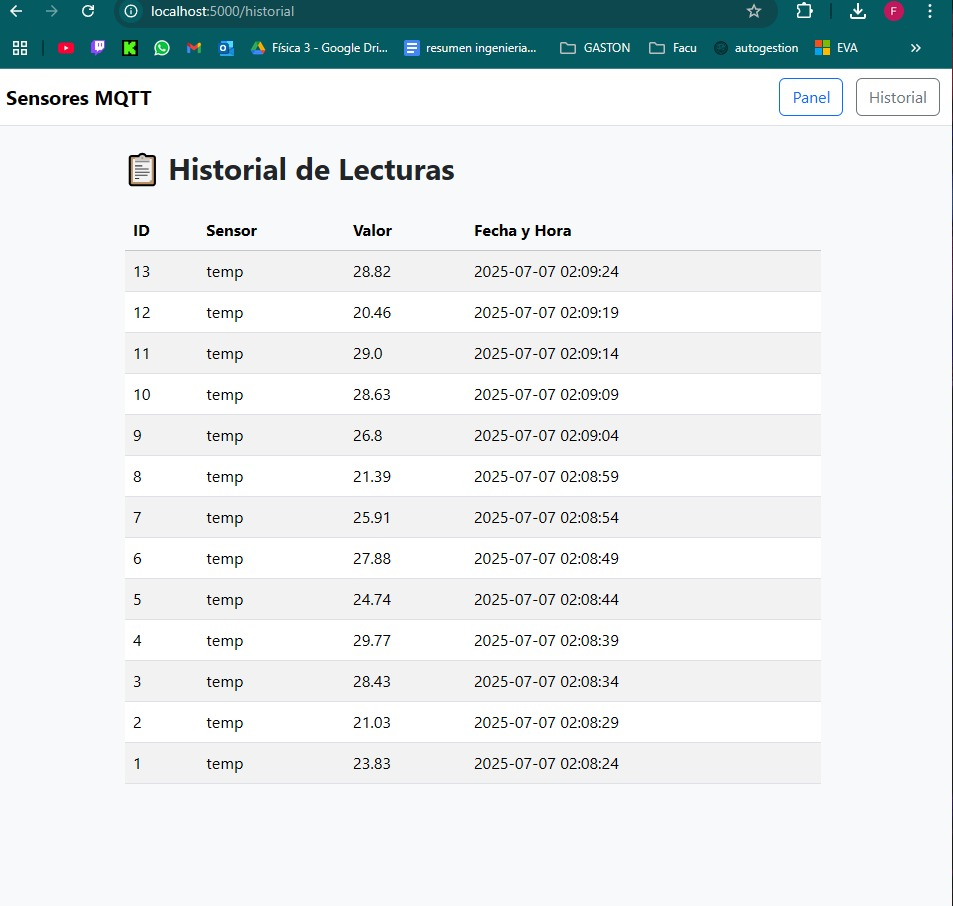
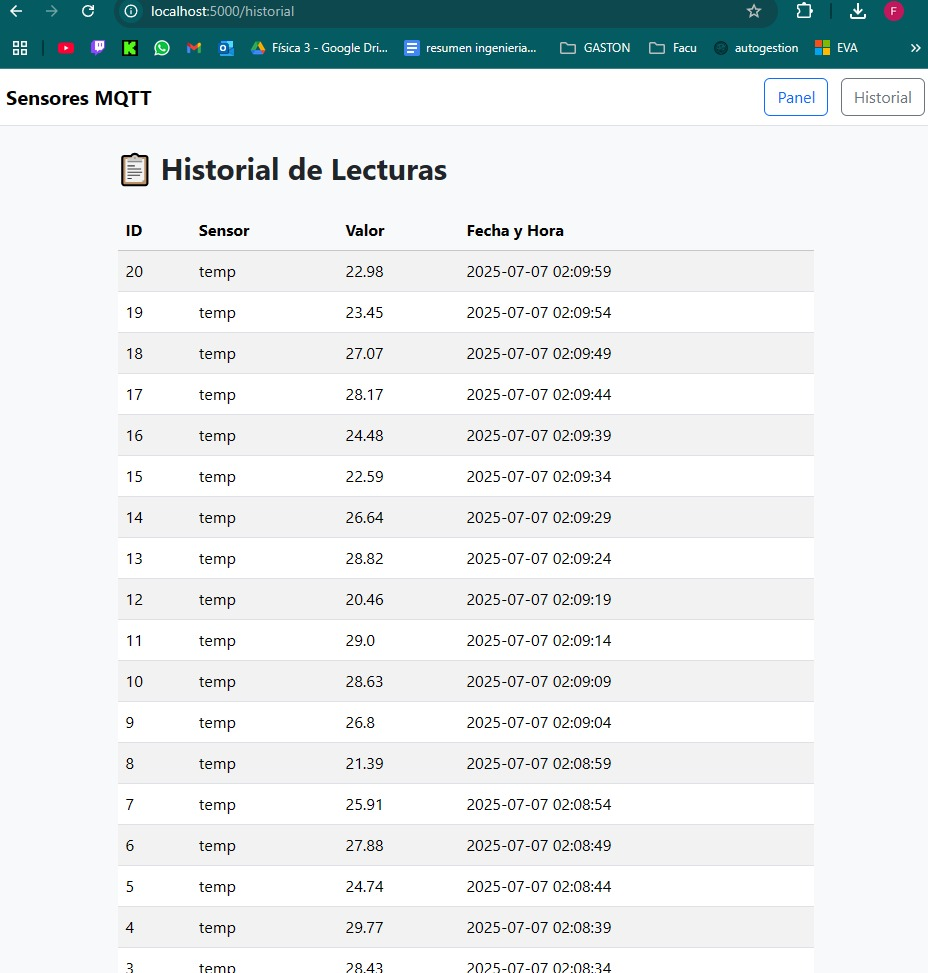
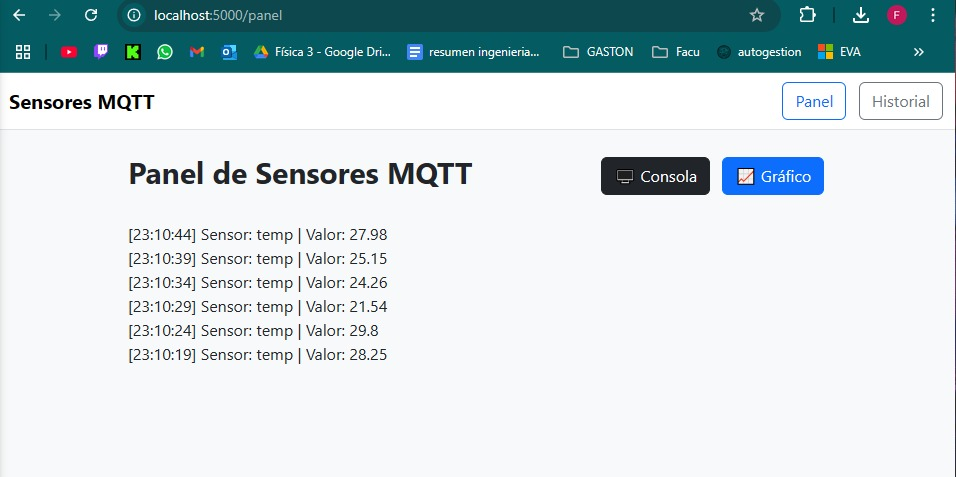
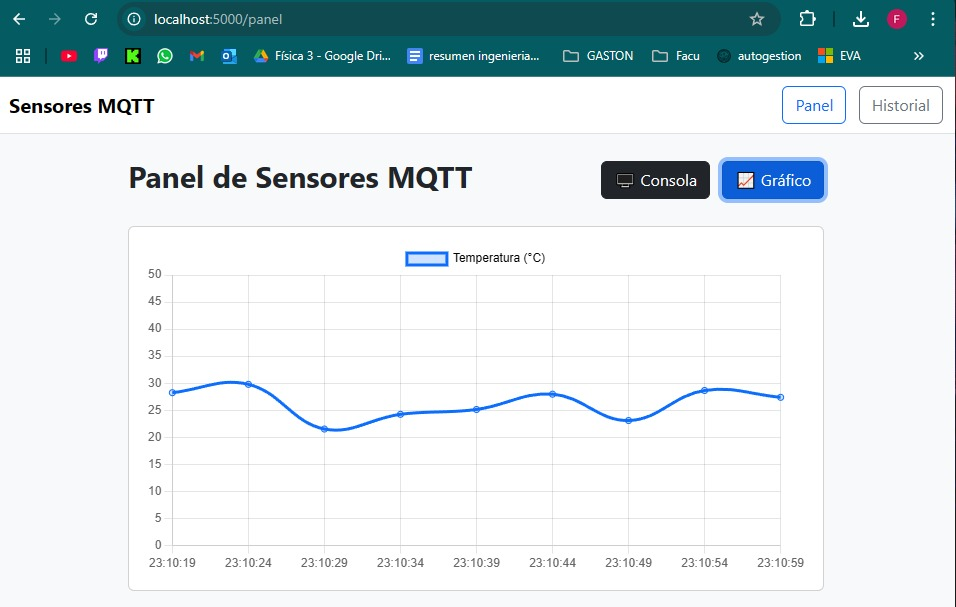
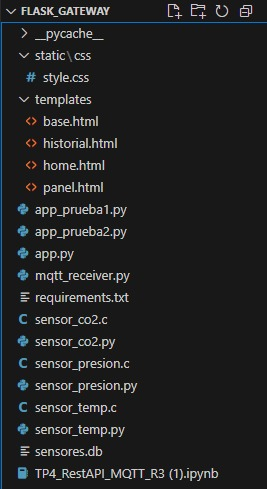
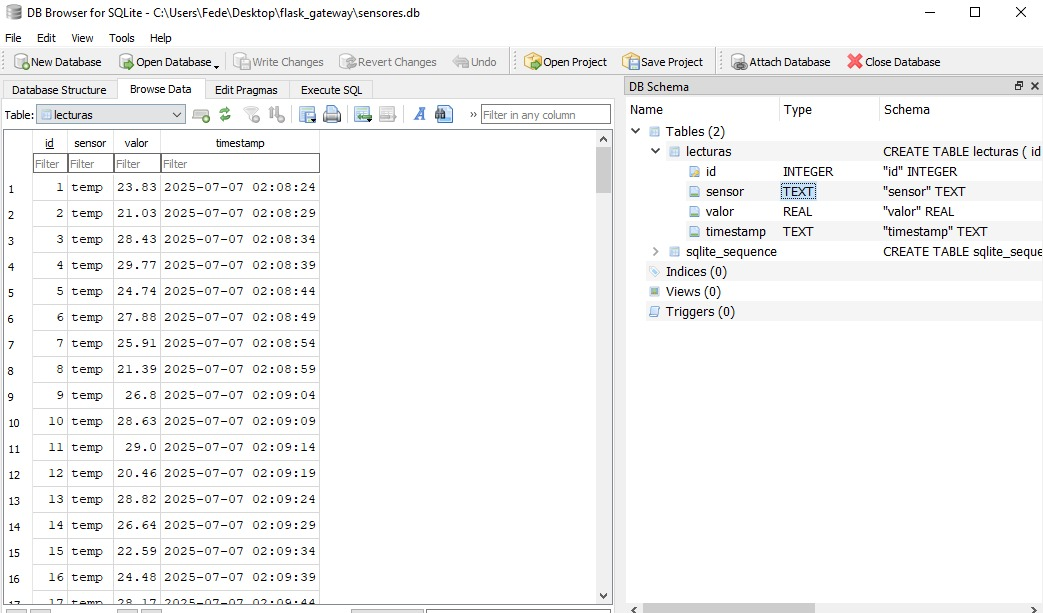